# Image Evals for Image Generation and Editing Use Cases

## Introduction

Image models are increasingly used in real product workflows—design
mockups, marketing assets, virtual try-on, and high-precision edits to
existing brand materials. To trust these systems in production, you need
more than “does it look good?” You need **repeatable, workflow-specific
evaluation** that measures whether outputs satisfy requirements, fail
safely, and improve predictably over time.

Vision evals are harder than text evals because the “answer” is an image
that mixes:

- **Hard constraints**: exact text, counts, attributes, locality
  (“change only this region”).  
- **Perceptual quality**: sharpness, coherence, realism, aesthetic
  match.  
- **Hidden failure modes**: subtle distortions, unintended edits, or
  small text errors that look fine at a glance but break product
  requirements—especially in editing.

A good vision eval does **not** score “a pretty picture.” It scores
whether the model is **reliable for a specific workflow**. Many images
that look visually strong still fail because text is wrong, style is
off-brand, or edits spill beyond the intended area. Image evals measure
**quality, controllability, and usability** for real prompts—not just
visual appeal.

### What this guide covers

This cookbook focuses on building a practical image-eval system for two
major categories:

**1) [Image generation evals](#image-generation-evals)**

- Instruction following (constraints satisfied)  
- Text rendering (accuracy, legibility, placement)  
- Style control (aesthetic match, brand/character consistency)  
- Preference alignment (rubric labels + pairwise comparisons)

**2) [Image editing evals](#image-editing-evals) (optionally with input
images and masks)**

- Transformation correctness (the requested change is done exactly)  
- Locality (edits happen only where intended)  
- Preservation (unrequested regions remain unchanged)  
- Spatial control (edits applied to the correct instance / region)

**3) Human feedback alignment**

- Rubric-based labels and pairwise preferences to capture subjective
  quality and “vibe”  
- Calibration techniques to keep human judgments consistent over time

**4) A staged strategy for building evals**

- Start with non-negotiable correctness gates  
- Add graded quality metrics once failures are controlled  
- Tag failure modes to drive targeted iteration

## Building a Vision Eval Harness

A vision eval harness is a small, repeatable system that turns “did this
image work?” into **structured, comparable results** across prompts,
models, and settings.

At a high level, vision evals follow the same loop as any LLM eval
system:

**Inputs → Model → Outputs → Graders → Scores → Feedback → Improvement**

To make this reusable across the rest of the cookbook (generation +
editing), build the harness around **three plug-ins**:

1.  **Test cases:** what to run (prompt + criteria + optional input
    images/mask)  
2.  **Runners:** how to call a model and save output images  
3.  **Graders:** how to score an output (rubrics, LLM-as-judge, human
    labels later)

Below is a minimal `vision_harness/` package you can drop into your
repo.

### vision_harness/types.py

Keep the core types generic so you can reuse them for *both* image
generation and image editing.


In [43]:
from __future__ import annotations

from dataclasses import dataclass, field
from pathlib import Path
from typing import Any, Literal, Optional

TaskType = Literal["image_generation", "image_editing"]
ScoreValue = bool | int | float | str


@dataclass(frozen=True)
class ImageInputs:
    """Editing inputs: one or more reference images + optional mask."""
    image_paths: list[Path]
    mask_path: Optional[Path] = None


@dataclass(frozen=True)
class TestCase:
    """A single evaluable example."""
    id: str
    task_type: TaskType
    prompt: str
    criteria: str
    image_inputs: Optional[ImageInputs] = None


@dataclass(frozen=True)
class ModelRun:
    """One model configuration to evaluate (useful for sweeps)."""
    label: str
    task_type: TaskType
    params: dict[str, Any]  # e.g. {"model": "...", "quality": "...", ...}


@dataclass(frozen=True)
class Artifact:
    """A saved artifact from a run (usually an image)."""
    kind: Literal["image"]
    path: Path
    mime: str = "image/png"


@dataclass
class ModelResponse:
    """Normalized output from any runner."""
    artifacts: list[Artifact] = field(default_factory=list)
    raw: dict[str, Any] = field(default_factory=dict)  # optional debug payload


@dataclass(frozen=True)
class Score:
    key: str
    value: ScoreValue
    reason: str = ""
    tags: Optional[list[str]] = None


### vision_harness/io.py

You’ll use this in graders (LLM-as-judge) and sometimes in model calls.


In [44]:
from __future__ import annotations

import base64
from pathlib import Path

_MIME_BY_SUFFIX = {
    ".jpg": "image/jpeg",
    ".jpeg": "image/jpeg",
    ".png": "image/png",
    ".webp": "image/webp",
}

def image_to_data_url(path: Path) -> str:
    mime = _MIME_BY_SUFFIX.get(path.suffix.lower(), "image/png")
    b64 = base64.b64encode(path.read_bytes()).decode("utf-8")
    return f"data:{mime};base64,{b64}"


### vision_harness/storage.py


In [45]:
from __future__ import annotations

import time
from dataclasses import dataclass
from pathlib import Path

@dataclass
class OutputStore:
    """Simple artifact store that writes directly to the root folder."""
    root: Path

    def run_dir(self, test_id: str, model_label: str) -> Path:
        # Ignore test/model subfolders; write everything to the root.
        self.root.mkdir(parents=True, exist_ok=True)
        return self.root

    def new_basename(self, prefix: str) -> str:
        created_ms = int(time.time() * 1000)
        return f"{prefix}_{created_ms}"

    def save_png(self, run_dir: Path, basename: str, idx: int, png_bytes: bytes) -> Path:
        out = run_dir / f"{basename}_{idx}.png"
        out.write_bytes(png_bytes)
        return out


### vision_harness/sweeps.py


In [46]:
from __future__ import annotations

from itertools import product
from typing import Any


def grid_sweep(
    *,
    base_label: str,
    task_type: TaskType,
    fixed: dict[str, Any],
    grid: dict[str, list[Any]],
) -> list[ModelRun]:
    keys = list(grid.keys())
    runs: list[ModelRun] = []

    for values in product(*[grid[k] for k in keys]):
        params = dict(fixed)
        label_parts = [base_label]
        for k, v in zip(keys, values):
            params[k] = v
            label_parts.append(f"{k}={v}")
        runs.append(ModelRun(label=",".join(label_parts), task_type=task_type, params=params))

    return runs


### vision_harness/runners.py

Two runners: one for **generation**, one for **editing**. Both return a
normalized `ModelResponse` containing saved output images.


In [47]:
from __future__ import annotations

import base64
from contextlib import ExitStack
from typing import Optional

from openai import OpenAI


def _mime_for_path(path) -> str:
    suffix = str(path).lower()
    if suffix.endswith(".png"):
        return "image/png"
    if suffix.endswith(".jpg") or suffix.endswith(".jpeg"):
        return "image/jpeg"
    if suffix.endswith(".webp"):
        return "image/webp"
    return "application/octet-stream"


def _extract_b64_items(images_response) -> list[str]:
    b64_items: list[str] = []
    for item in getattr(images_response, "data", []) or []:
        b64 = getattr(item, "b64_json", None)
        if b64:
            b64_items.append(b64)
    return b64_items


class ImageGenerationRunner:
    """Text-to-image runner."""

    def __init__(self, client: Optional[OpenAI] = None):
        self.client = client or OpenAI()

    def run(self, case: TestCase, run_cfg: ModelRun, store: OutputStore) -> ModelResponse:
        assert case.task_type == "image_generation"
        assert run_cfg.task_type == "image_generation"

        params = dict(run_cfg.params)
        model = params.pop("model")
        n = int(params.pop("n", 1))

        run_dir = store.run_dir(case.id, run_cfg.label)
        basename = store.new_basename(f"gen_{case.id}_{run_cfg.label}")

        images_response = self.client.images.generate(
            model=model,
            prompt=case.prompt,
            n=n,
            **params,
        )

        artifacts: list[Artifact] = []
        for idx, b64_json in enumerate(_extract_b64_items(images_response)):
            png_bytes = base64.b64decode(b64_json)
            out_path = store.save_png(run_dir, basename, idx, png_bytes)
            artifacts.append(Artifact(kind="image", path=out_path))

        return ModelResponse(artifacts=artifacts, raw={"model": model, "params": run_cfg.params})


class ImageEditRunner:
    """Image editing runner (reference image(s) + optional mask)."""

    def __init__(self, client: Optional[OpenAI] = None):
        self.client = client or OpenAI()

    def run(self, case: TestCase, run_cfg: ModelRun, store: OutputStore) -> ModelResponse:
        assert case.task_type == "image_editing"
        assert run_cfg.task_type == "image_editing"
        assert case.image_inputs is not None and case.image_inputs.image_paths

        params = dict(run_cfg.params)
        model = params.pop("model")
        n = int(params.pop("n", 1))

        run_dir = store.run_dir(case.id, run_cfg.label)
        basename = store.new_basename(f"edit_{case.id}_{run_cfg.label}")

        with ExitStack() as stack:
            image_files = []
            for p in case.image_inputs.image_paths:
                f = stack.enter_context(p.open("rb"))
                image_files.append((p.name, f, _mime_for_path(p)))

            mask_file = None
            if case.image_inputs.mask_path:
                mf = stack.enter_context(case.image_inputs.mask_path.open("rb"))
                mask_file = (case.image_inputs.mask_path.name, mf, _mime_for_path(case.image_inputs.mask_path))

            edit_kwargs = dict(
                model=model,
                prompt=case.prompt,
                image=image_files,
                n=n,
                **params,
            )
            if mask_file is not None:
                edit_kwargs["mask"] = mask_file

            images_response = self.client.images.edit(**edit_kwargs)

        artifacts: list[Artifact] = []
        for idx, b64_json in enumerate(_extract_b64_items(images_response)):
            png_bytes = base64.b64decode(b64_json)
            out_path = store.save_png(run_dir, basename, idx, png_bytes)
            artifacts.append(Artifact(kind="image", path=out_path))

        return ModelResponse(artifacts=artifacts, raw={"model": model, "params": run_cfg.params})


### vision_harness/graders.py

A clean grader interface + a reusable **LLM-as-judge** grader that can
be used for both generation and editing by changing how you build the
judge inputs.


In [48]:
from __future__ import annotations

import json
from dataclasses import dataclass, field
from pathlib import Path
from typing import Callable, Optional, Protocol

from openai import OpenAI


class Grader(Protocol):
    key: str

    def grade(self, response: ModelResponse, case: TestCase) -> Score | list[Score]: ...


def pick_first_image(response: ModelResponse) -> Optional[Path]:
    for artifact in response.artifacts:
        if artifact.kind == "image":
            return artifact.path
    return None


def build_generation_judge_content(case: TestCase, output_image: Path) -> list[dict]:
    return [
        {
            "type": "input_text",
            "text": f"Prompt:\n{case.prompt}\n\nCriteria:\n{case.criteria}",
        },
        {
            "type": "input_image",
            "image_url": image_to_data_url(output_image),
        },
    ]


def build_editing_judge_content(case: TestCase, output_image: Path) -> list[dict]:
    assert case.image_inputs is not None and case.image_inputs.image_paths
    content: list[dict] = [
        {
            "type": "input_text",
            "text": f"Edit instruction:\n{case.prompt}\n\nCriteria:\n{case.criteria}",
        }
    ]
    for image_path in case.image_inputs.image_paths:
        content.append(
            {
                "type": "input_image",
                "image_url": image_to_data_url(image_path),
            }
        )
    if case.image_inputs.mask_path:
        content.append(
            {
                "type": "input_image",
                "image_url": image_to_data_url(case.image_inputs.mask_path),
            }
        )
    content.append(
        {
            "type": "input_image",
            "image_url": image_to_data_url(output_image),
        }
    )
    return content


def default_schema() -> dict:
    return {
        "type": "object",
        "properties": {
            "pass": {"type": "boolean"},
            "reason": {"type": "string"},
        },
        "required": ["pass", "reason"],
        "additionalProperties": False,
    }


@dataclass
class LLMajRubricGrader:
    """
    Reusable vision LLM-as-judge grader.
    - Provide a system prompt + a content_builder for generation/editing.
    - Optionally provide a custom JSON schema and parser.
    """

    key: str
    system_prompt: str
    content_builder: Callable[[TestCase, Path], list[dict]]
    judge_model: str = "gpt-5.2"
    client: Optional[OpenAI] = None

    json_schema_name: str = "vision_eval_result"
    json_schema: dict = field(default_factory=default_schema)
    result_parser: Optional[Callable[[dict, str], Score | list[Score]]] = None

    def _parse_result(self, data: dict) -> Score | list[Score]:
        if self.result_parser:
            return self.result_parser(data, self.key)
        return Score(
            key=self.key,
            value=bool(data.get("pass", False)),
            reason=(data.get("reason") or "").strip(),
            tags=data.get("tags") or None,
        )

    def grade(self, response: ModelResponse, case: TestCase) -> Score | list[Score]:
        output_image = pick_first_image(response)
        if not output_image:
            return Score(key=self.key, value=False, reason="No output image artifact found")

        client = self.client or OpenAI()
        content = self.content_builder(case, output_image)

        completion = client.responses.create(
            model=self.judge_model,
            input=[
                {"role": "system", "content": self.system_prompt},
                {"role": "user", "content": content},
            ],
            text={
                "format": {
                    "type": "json_schema",
                    "name": self.json_schema_name,
                    "schema": self.json_schema,
                    "strict": True,
                }
            },
        )

        data = json.loads(completion.output_text)
        return self._parse_result(data)


### vision_harness/evaluate.py

A simple evaluation loop that returns plain Python data (no “eval row”
class). Later sections can write their own reporting/CSV utilities on
top.


In [49]:
from __future__ import annotations

from typing import Any


def _as_score_list(score_or_scores: Score | list[Score]) -> list[Score]:
    if isinstance(score_or_scores, list):
        return score_or_scores
    return [score_or_scores]


def evaluate(
    *,
    cases: list[TestCase],
    model_runs: list[ModelRun],
    graders: list[Grader],
    output_store: OutputStore,
) -> list[dict[str, Any]]:
    gen_runner = ImageGenerationRunner()
    edit_runner = ImageEditRunner()

    results: list[dict[str, Any]] = []

    for case in cases:
        for run_cfg in model_runs:
            if run_cfg.task_type != case.task_type:
                continue

            if case.task_type == "image_generation":
                response = gen_runner.run(case, run_cfg, output_store)
            elif case.task_type == "image_editing":
                response = edit_runner.run(case, run_cfg, output_store)
            else:
                raise ValueError(f"Unknown task_type: {case.task_type}")

            score_map: dict[str, Any] = {}
            reason_map: dict[str, str] = {}

            for grader in graders:
                scored = grader.grade(response, case)
                for score in _as_score_list(scored):
                    score_map[score.key] = score.value
                    reason_map[score.key] = score.reason

            results.append(
                {
                    "test_id": case.id,
                    "model_label": run_cfg.label,
                    "task_type": case.task_type,
                    "artifact_paths": [str(a.path) for a in response.artifacts],
                    "scores": score_map,
                    "reasons": reason_map,
                    "run_params": run_cfg.params,
                }
            )

    return results


### Result Table Rendering Helpers

In [50]:
import os
from html import escape
from IPython.display import HTML, display


def summarize_scores(scores: dict[str, object]) -> str:
    return os.linesep.join(f"{k}: {scores[k]}" for k in sorted(scores.keys()))


def summarize_reasons(reasons: dict[str, str]) -> str:
    verdict_reason = (reasons.get("verdict") or "").strip()
    if verdict_reason:
        return verdict_reason
    return os.linesep.join(f"{k}: {reasons[k]}" for k in sorted(reasons.keys()) if reasons[k])


def _pre(text: str) -> str:
    return (
        "<pre style='white-space:pre-wrap; word-break:break-word; margin:0'>"
        f"{escape(text)}"
        "</pre>"
    )


def render_result_table(
    *,
    case: TestCase,
    result: dict[str, object],
    title: str,
    image_max_width: int = 560,
) -> None:
    sep = os.linesep
    prompt_text = f"{case.prompt}{sep}{sep}Criteria:{sep}{case.criteria}"
    image_path = Path(result["artifact_paths"][0])
    scores = result["scores"]
    reasons = result["reasons"]

    image_html = (
        "<img src='"
        f"{image_to_data_url(image_path)}"
        f"' style='max-width:{image_max_width}px; width:100%; border:1px solid #ddd; border-radius:8px'/>"
    )

    prompt_html = _pre(prompt_text)
    scores_html = _pre(summarize_scores(scores))
    reasons_html = _pre(summarize_reasons(reasons))

    table_html = (
        "<table style='width:100%; table-layout:fixed; border-collapse:collapse;'>"
        "<colgroup>"
        "<col style='width:25%'>"
        "<col style='width:25%'>"
        "<col style='width:25%'>"
        "<col style='width:25%'>"
        "</colgroup>"
        "<thead><tr>"
        "<th style='text-align:left; padding:8px; border-bottom:1px solid #ddd'>Image</th>"
        "<th style='text-align:left; padding:8px; border-bottom:1px solid #ddd'>Input Prompt</th>"
        "<th style='text-align:left; padding:8px; border-bottom:1px solid #ddd'>Scores</th>"
        "<th style='text-align:left; padding:8px; border-bottom:1px solid #ddd'>Reasoning</th>"
        "</tr></thead>"
        "<tbody><tr>"
        f"<td style='padding:8px; vertical-align:top'>{image_html}</td>"
        f"<td style='padding:8px; vertical-align:top'>{prompt_html}</td>"
        f"<td style='padding:8px; vertical-align:top'>{scores_html}</td>"
        f"<td style='padding:8px; vertical-align:top'>{reasons_html}</td>"
        "</tr></tbody></table>"
    )

    display(HTML(f"<div style='font-weight:600; margin:6px 0'>{escape(title)}</div>"))
    display(HTML(table_html))




Later cookbook sections will only need to provide:

1.  A list of `TestCase` objects for the use case (UI mockups, marketing
    graphics, virtual try-on, logo edits, etc.)  
2.  A set of `ModelRun`s (single run or a sweep with `grid_sweep`)  
3.  A set of graders, typically:
    - **Gating graders** (pass/fail): non-negotiables ex: instruction
      following, text correctness, locality/preservation  
    - **Graded metrics** (0–5): quality dimensions ex:
      realism/usability, layout/hierarchy, artifact severity  
    - Optional: human rubric labels and pairwise prefs (stored outside
      the harness)

This keeps the rest of the cookbook focused on **what to measure** per
use case—without rewriting harness plumbing each time.

## Image Generation Evals

**Use Case Ideas: UI mockups, marketing graphics/posters**

**Goal: evaluate text-to-image quality, controllability, and usefulness
for real prompts**  
Covers:

- **instruction following** (constraints satisfied),  
- **Text rendering** (generated text is accurate, legible, and placed
  correctly),  
- **Styling** (requested aesthetic + visual quality, may include brand,
  character, and product consistency)  
- **Human feedback alignment** (rubric-based labels + pairwise prefs).

Image generation models are used to create artifacts that influence real
work: UI mockups, product designs, marketing graphics, and internal
presentations. In these contexts, images are not judged purely on visual
appeal. They are judged on whether they communicate intent, follow
constraints, and are usable by downstream stakeholders.

### UI Mockups

UI mockups generated by image models are increasingly used for early
product exploration, design ideation, and internal reviews. In these
workflows, mockups are not just visual inspiration. They are
communication tools that help designers, engineers, and stakeholders
reason about layout, hierarchy, interaction intent, and feature scope
before anything is built. As a result, success is defined less by
aesthetic taste and more by whether the output can plausibly function as
a product artifact.

This section shows how to evaluate a generated UI mockup using a screen
level example. The goal is to evaluate whether the generated UI consists
of a coherent layout, uses recognizable components, and represents a
plausible product experience.

**Why UI mockup evals are different**

UI mockups combine several difficult evaluation dimensions:

1.  **Component Fidelity (gating)**  
    The generated image must clearly depict the requested screen type
    and state. Buttons should look clickable, inputs should look
    editable, and navigation should look like navigation.  
2.  **Layout Realization (graded)**  
    A good UI mockup communicates instantly what the user can do and
    what matters most. The layout should make primary actions obvious,
    secondary actions clearly subordinate, and information grouped in a
    way that reflects real interaction flow  
3.  **In-Image Text Rendering (gating)**  
    UI text encodes functionality. Labels, headings, and calls to action
    must be legible and correctly rendered.

**Example task: mobile checkout screen generation**

- Scenario: a consumer ecommerce app needs a mobile checkout screen to
  review an order and complete payment.
- Prompt guidance: be explicit about screen type, platform, required UI
  elements, exact button/link text, hierarchy constraints, and
  disallowed extras.
- Implementation: the full prompt and criteria live in the harness
  setup code cell below (`ui_prompt` and `ui_criteria`).

#### What to evaluate (practical metrics):

##### 1) Instruction Following — Pass / Fail (gate)

Most UI mockup evals start with instruction fidelity. At a basic level,
the question is simple: did the model generate the screen that was asked
for? If the prompt specifies a mobile checkout screen, the output should
look like a mobile checkout screen, not a generic landing page. Required
sections, states, or constraints should be present, and the overall
structure should match the intent of the request. This dimension is
often the most heavily weighted, because if the model misses the core
ask, the rest of the output does not matter. Once a UI mockup satisfies
the basic instruction, evaluation shifts to whether the screen is usable
and coherent as a product artifact.

**PASS if**

- The correct screen type and platform context are present.  
- All required sections, states, or constraints are included.

**FAIL if**

- Missing any required components or the output alters the UI’s purpose.

##### 2) Layout and Hierarchy — 0–5

Measures whether the screen communicates clearly at a glance.

**What to look for:**

- Clear visual hierarchy between primary and secondary actions  
- Consistent alignment and spacing  
- Logical grouping of related elements

##### 3) Text rendering and legibility — Pass / Fail (gate)

Labels, headings, and calls to action need to be readable and
unambiguous.

**PASS if**

- Text is readable, correctly spelled, and sensibly labeled.  
- Font sizes reflect hierarchy (headings vs labels vs helper text).

**FAIL if**

- Any critical text is unreadable, cut off, misspelled, or distorted.

##### 4) UI Realism and Usability — *0–5*

Measures whether the mockup resembles a plausible product interface.

**What to look for:**

- Inputs look editable / Buttons look clickable  
- Navigation looks like navigation  
- Interactive elements are visually distinct from static content

**Verdict rules (how to convert metrics into a single pass/fail)**

- **Instruction Following must PASS**  
- **Layout and Hierarchy ≥ 3**  
- **Text Rendering must PASS**  
- **UI Realism ≥ 3**

If any rule fails → overall **FAIL**.

**Example `TestCase` set (small but high-signal)**

Start with a few cases that cover common UI mockup variants and edge
cases.

1.  **Mobile** **checkout screen** (the “checkout UI mockup” prompt
    above)  
2.  **Minimal layout** (header + order total + primary CTA only) - tests
    layout and hierarchy with sparse elements.  
3.  **Dense hierarchy** (order summary + payment method + promo row +
    taxes + two secondary actions) - tests hierarchy under information
    load.  
4.  **Exact CTA text** (primary button text must be exactly “Place
    Order”) - tests in-image text rendering fidelity.  
5.  **Secondary action presence (i**nclude both “Edit Cart” and “Change
    payment method”) - tests secondary actions remain visually
    subordinate.  
6.  **Placement constraint** (require order total directly above the
    primary CTA)  
7.  **Platform fidelity** (mobile vs desktop version) - tests screen
    framing and platform cues.

**LLM-as-judge rubric prompt**

Below is a judge prompt aligned to your existing `LLMajRubricGrader`. It
returns structured metric scores + an overall verdict.

You can use this with your existing grader by changing the JSON schema
to include the fields below (or create separate graders per metric if
you prefer).

#### System Prompt (UI mockup judge)


In [51]:
PROMPT = """<core_mission>
Evaluate whether a generated UI mockup image represents a usable mobile checkout screen by checking screen type fidelity, layout realization, in-image text rendering, and UI affordance clarity.
</core_mission>

<role>
You are an expert evaluator of UI mockups used by designers and engineers. You care about structural correctness, readable UI text, clear hierarchy,and realistic rendering of UI elements.
</role>

<scope_constraints>
- Judge only against the provided instructions.
- Be strict about required UI elements and exact button/link text.
- Do NOT infer intent beyond what is explicitly stated.
- Do NOT reward creativity that violates constraints.
- Missing or extra required components are serious errors.
- If the UI intent or function is unclear, score conservatively.
</scope_constraints>

<metrics>
1) instruction_following: PASS/FAIL
2) ui_layout_realization: 0–5
3) in_image_text_rendering: PASS / FAIL
4) ui_affordance_rendering: 0–5
</metrics>

Use these anchors:
Evaluate EACH metric independently using the definitions below.
--------------------------------
1) Instruction Following (PASS / FAIL)
--------------------------------
PASS if:
- All required components are present.
- No unrequested components or features are added.
- The screen matches the requested type and product context.

FAIL if:
- Any required component is missing.
- Any unrequested component materially alters the UI.
- The screen does not match the requested type.

--------------------------------
2) Layout and Hierarchy (0–5)
--------------------------------
5: Layout is clear, coherent, and immediately usable.
   Hierarchy, grouping, spacing, and alignment are strong.

3: Generally understandable, but one notable hierarchy or layout issue
   that would require iteration.

0-2: Layout problems materially hinder usability or comprehension.

--------------------------------
3) In Image Text Rendering (PASS / FAIL)
--------------------------------
PASS if
- Text is readable, correctly spelled, and sensibly labeled.
- Font sizes reflect hierarchy (headings vs labels vs helper text).

FAIL if
- Any critical text is unreadable, cut off, misspelled, or distorted.

--------------------------------
4) UI Realism and Usability (0–5)
--------------------------------
5: Clearly resembles a real product interface that designers could use.

3: Marginally plausible; intent is visible but execution is weak.

0-2: Poor realism; interface would be difficult to use in practice.

<verdict_rules>
- Instruction Following must PASS.
- Text Rendering must PASS.
- Layout and Hierarchy score must be ≥ 3.
- UI Realism and Usability score must be ≥ 3.

If ANY rule fails, the overall verdict is FAIL.
Do not average scores to determine the verdict.
</verdict_rules>

<output_constraints>
Return JSON only.
No extra text.
</output_constraints>
"""

#### Recommended JSON Output


In [52]:
{
  "verdict": "PASS",
  "instruction_following": True,
  "layout_hierarchy": 3,
  "in_image_text_rendering": True,
  "ui_affordance_rendering": 4,
  "reason": "..."
}


{'verdict': 'PASS',
 'instruction_following': True,
 'layout_hierarchy': 3,
 'in_image_text_rendering': True,
 'ui_affordance_rendering': 4,
 'reason': '...'}

##### 5) Human feedback (quick and high leverage)

UI "usability clarity" is where humans add the most value. Keep it lightweight and focused on interaction intent.

- Rubric labels (fast):
  - Would you use this mockup to iterate on a real product screen? (Y/N)
  - If N, why? (missing section, action button unclear, text unreadable, layout confusing, etc.)
  - Overall usability clarity: 1–5
- Common failure tags (for debugging + iteration):
  - `wrong_screen_type`
  - `missing_required_section`
  - `extra_ui_elements`
  - `primary_cta_not_clear`
  - `text_unreadable_or_garbled`
  - `affordances_unclear`
  - `layout_confusing`




### UI Mockup Example: Harness Setup

Define a UI mockup test case, a model run, and an output store under `images/`.


In [75]:
# Capture the UI judge prompt before PROMPT is overwritten later.
ui_judge_prompt = PROMPT

ui_prompt = """Generate a high-fidelity mobile checkout screen for an ecommerce app.
Orientation: portrait.
Screen type: checkout / order review.
Use the REQUIRED TEXT:
- Checkout
- Place Order
- Edit Cart
Constraints:
- Order total appears directly above the primary CTA.
- Primary CTA is the most visually prominent element.
- Do not include popups, ads, marketing copy, or extra screens.
- Do not include placeholder or lorem ipsum text.
"""

ui_criteria = """The image clearly depicts a mobile checkout screen.
All required sections are present and visually distinct.
UI elements look clickable/editable and follow common conventions.
Primary vs secondary actions are unambiguous.
No extra UI states, decorative noise, or placeholder text."""

ui_case = TestCase(
    id="ui_checkout_mockup",
    task_type="image_generation",
    prompt=ui_prompt,
    criteria=ui_criteria,
)

ui_run = ModelRun(
    label="gpt-image-1.5-ui",
    task_type="image_generation",
    params={
        "model": "gpt-image-1.5",
        "n": 1,
        "size": "1024x1024",
    },
)

ui_store = OutputStore(root=Path("../../images"))




### UI Mockup Example: Run And Grade

Run the harness and grade the UI mockup using the UI judge rubric.


In [76]:
ui_schema = {
    "type": "object",
    "properties": {
        "verdict": {"type": "string"},
        "instruction_following": {"type": "boolean"},
        "layout_hierarchy": {"type": "number"},
        "in_image_text_rendering": {"type": "boolean"},
        "ui_affordance_rendering": {"type": "number"},
        "reason": {"type": "string"},
    },
    "required": [
        "verdict",
        "instruction_following",
        "layout_hierarchy",
        "in_image_text_rendering",
        "ui_affordance_rendering",
        "reason",
    ],
    "additionalProperties": False,
}


def parse_ui_result(data: dict, base_key: str) -> list[Score]:
    return [
        Score(key="instruction_following", value=bool(data["instruction_following"]), reason=""),
        Score(key="layout_hierarchy", value=float(data["layout_hierarchy"]), reason=""),
        Score(key="in_image_text_rendering", value=bool(data["in_image_text_rendering"]), reason=""),
        Score(key="ui_affordance_rendering", value=float(data["ui_affordance_rendering"]), reason=""),
        Score(key="verdict", value=str(data["verdict"]), reason=(data.get("reason") or "").strip()),
    ]

ui_grader = LLMajRubricGrader(
    key="ui_eval",
    system_prompt=ui_judge_prompt,
    content_builder=build_generation_judge_content,
    judge_model="gpt-5.2",
    json_schema_name="ui_mockup_eval",
    json_schema=ui_schema,
    result_parser=parse_ui_result,
)

ui_results = evaluate(
    cases=[ui_case],
    model_runs=[ui_run],
    graders=[ui_grader],
    output_store=ui_store,
)

ui_result = ui_results[0]
ui_result


{'test_id': 'ui_checkout_mockup',
 'model_label': 'gpt-image-1.5-ui',
 'task_type': 'image_generation',
 'artifact_paths': ['../../images/gen_ui_checkout_mockup_gpt-image-1.5-ui_1769489301415_0.png'],
 'scores': {'instruction_following': True,
  'layout_hierarchy': 5.0,
  'in_image_text_rendering': True,
  'ui_affordance_rendering': 5.0,
  'verdict': 'PASS'},
 'reasons': {'instruction_following': '',
  'layout_hierarchy': '',
  'in_image_text_rendering': '',
  'ui_affordance_rendering': '',
  'verdict': 'Meets prompt requirements: clearly a portrait mobile checkout/order review screen with distinct sections (Shipping Information, Items in Your Order, Order Summary). Required text appears exactly: "Checkout" (title), "Edit Cart" (top right), and primary CTA "Place Order". Order total ($261.50) is directly above the primary CTA, and the CTA is the most visually prominent element. No popups, ads, marketing copy, extra screens, or lorem/placeholder text. UI elements (back arrow, Change lin



### UI Mockup Example: Results Table

Show the prompt, generated image, and scores in a single pandas table.


Image,Input Prompt,Scores,Reasoning
,"Generate a high-fidelity mobile checkout screen for an ecommerce app. Orientation: portrait. Screen type: checkout / order review. Use the REQUIRED TEXT: - Checkout - Place Order - Edit Cart Constraints: - Order total appears directly above the primary CTA. - Primary CTA is the most visually prominent element. - Do not include popups, ads, marketing copy, or extra screens. - Do not include placeholder or lorem ipsum text. Criteria: The image clearly depicts a mobile checkout screen. All required sections are present and visually distinct. UI elements look clickable/editable and follow common conventions. Primary vs secondary actions are unambiguous. No extra UI states, decorative noise, or placeholder text.",in_image_text_rendering: True instruction_following: True layout_hierarchy: 5.0 ui_affordance_rendering: 5.0 verdict: PASS,"Meets prompt requirements: clearly a portrait mobile checkout/order review screen with distinct sections (Shipping Information, Items in Your Order, Order Summary). Required text appears exactly: ""Checkout"" (title), ""Edit Cart"" (top right), and primary CTA ""Place Order"". Order total ($261.50) is directly above the primary CTA, and the CTA is the most visually prominent element. No popups, ads, marketing copy, extra screens, or lorem/placeholder text. UI elements (back arrow, Change link, Edit Cart link, CTA button) read as interactive with conventional styling and clear primary vs secondary actions."

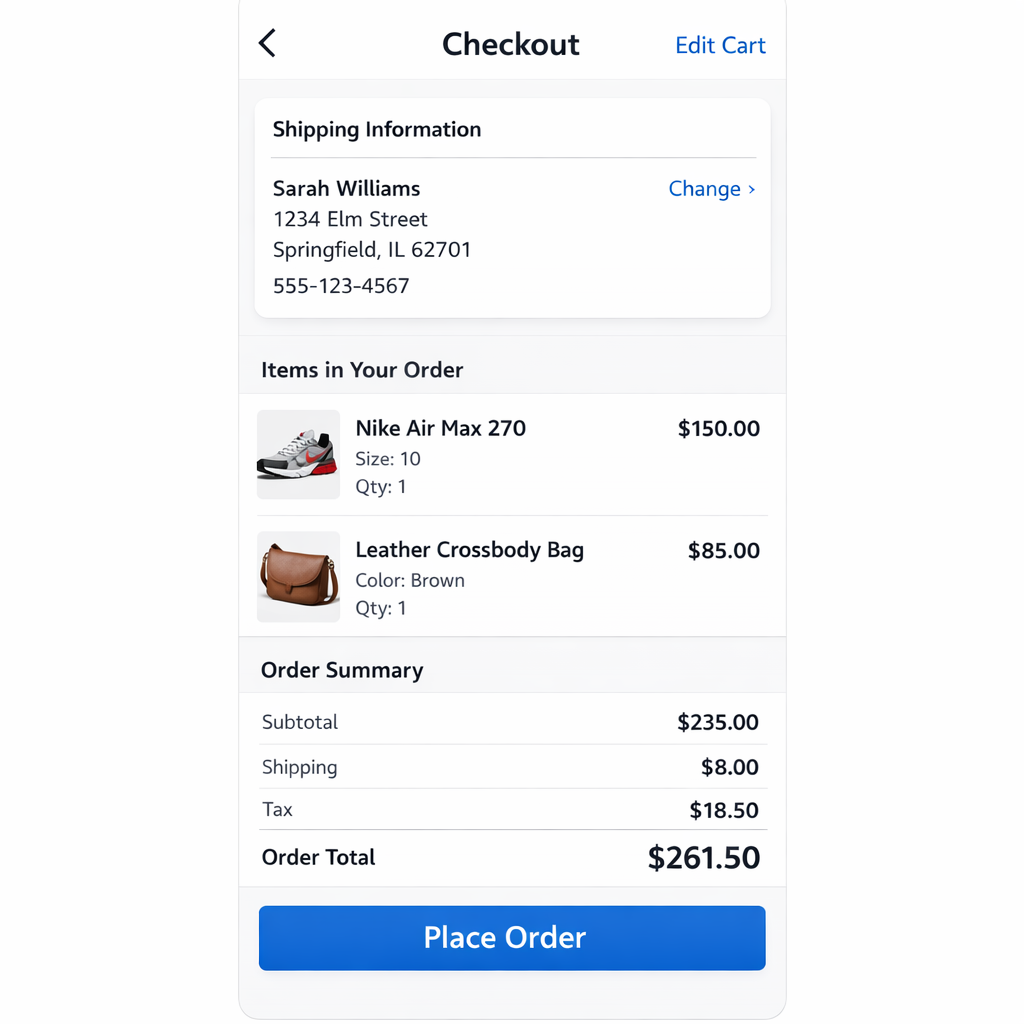

In [77]:
render_result_table(case=ui_case, result=ui_result, title="UI Mockup: Prompt vs. Scores")


### Marketing Graphics Generation

Marketing graphics are a “high-stakes text-to-image” workflow: the
output is meant to ship (or at least be reviewed as if it could ship).
A flyer can look “nice” but still fail if the copy is wrong, the offer
is unclear, or the layout hides the key message.

This section shows how to evaluate **flyer generation** with a coffee
shop example. The goal is to make evaluation workflow-relevant: can a
marketer or designer use this output with minimal edits?

**Why marketing graphics evals are different**

Marketing images combine three hard problem types:

1.  Exact text requirements (gating)
2.  Layout + hierarchy (graded)
3.  Style + brand consistency (graded + optional human prefs)

**Example task: Coffee shop flyer generation**

- Scenario: a local coffee shop needs a promotional flyer for a
  limited-time drink and a weekday deal.
- Prompt guidance: be explicit about the deliverable, required copy,
  hierarchy, and disallowed extras.
- Implementation: the full prompt and criteria live in the harness
  setup code cell below (`coffee_generation_prompt` and
  `coffee_criteria`).


In [56]:
PROMPT = """<core_mission>
Evaluate whether a generated marketing flyer is usable for a real coffee shop
promotion by checking instruction adherence, exact text correctness, layout clarity,
style fit, and artifact severity.
</core_mission>

<role>
You are an expert evaluator of marketing design deliverables.
You care about correctness, readability, hierarchy, and brand-fit.
You do NOT reward creativity that violates constraints.
</role>

<scope_constraints>
- Judge ONLY against the provided prompt and criteria.
- Be strict about required copy: spelling, punctuation, casing, and symbols must match exactly.
- Extra or missing text is a serious error.
- If unsure, score conservatively (lower score).
</scope_constraints>

<metrics>
1) instruction_following: PASS/FAIL
2) text_rendering: PASS/FAIL
3) layout_hierarchy: 0-5
4) style_brand_fit: 0-5
5) visual_quality: 0-5

Use these anchors:
Layout/Hierarchy 5 = instantly readable; clear order; strong spacing/alignment.
3 = understandable but needs iteration (one clear issue).
0-2 = confusing or hard to parse.

Style/Brand Fit 5 = clearly matches requested vibe; consistent; not off-style.
3 = generally matches but with noticeable mismatch.
0-2 = wrong style (e.g. cartoonish when photo-real requested).

Visual Quality 5 = clean; no distracting artifacts; hero image coherent.
3 = minor artifacts but still usable.
0-2 = obvious artifacts or distortions that break usability.
</metrics>

<verdict_rules>
Overall verdict is FAIL if:
- instruction_following is FAIL, OR
- text_rendering is FAIL, OR
- any of layout_hierarchy/style_brand_fit/visual_quality is < 3.
Otherwise PASS.
</verdict_rules>

<output_constraints>
Return JSON only.
No extra text.
</output_constraints>
"""


#### Recommended JSON Output


In [57]:
{
  "verdict": "PASS",
  "instruction_following": True,
  "text_rendering": True,
  "layout_hierarchy": 4,
  "style_brand_fit": 4,
  "visual_quality": 3,
  "reason": "..."
}

{'verdict': 'PASS',
 'instruction_following': True,
 'text_rendering': True,
 'layout_hierarchy': 4,
 'style_brand_fit': 4,
 'visual_quality': 3,
 'reason': '...'}



### Coffee Example: Harness Setup

Define a single marketing flyer test case, a model run, and an output store.


In [58]:
# Run the harness for a single coffee flyer generation case.

coffee_generation_prompt = """Create a print-ready vertical A4 flyer for a coffee shop called Sunrise Coffee.
Use a warm, cozy, minimal specialty coffee aesthetic (not cartoonish).
Required text (must be exact):
- WINTER LATTE WEEK
- Try our Cinnamon Oat Latte
- 20% OFF - Mon-Thu
- Order Ahead
- 123 Market St - 7am-6pm
Do not include any other words, prices, URLs, or QR codes.
"""

coffee_criteria = """All required text appears exactly as written and is legible.
Layout reads clearly: shop name -> headline -> subheadline -> offer -> CTA -> footer.
Style matches warm, cozy, specialty coffee and is not cartoonish.
No extra text, watermarks, or irrelevant UI-like elements."""

coffee_case = TestCase(
    id="coffee_flyer_generation",
    task_type="image_generation",
    prompt=coffee_generation_prompt,
    criteria=coffee_criteria,
)

coffee_run = ModelRun(
    label="gpt-image-1.5",
    task_type="image_generation",
    params={
        "model": "gpt-image-1.5",
        "n": 1,
        "size": "1024x1024",
    },
)

# Save artifacts under the repo images/ folder so they render on the site.
coffee_store = OutputStore(root=Path("../../images"))




### Coffee Example: Run And Grade

Run the harness and score the output with the marketing judge rubric.


In [59]:
# Use the prebuilt graders + evaluate helpers with a structured marketing schema.
from openai import OpenAI

marketing_schema = {
    "type": "object",
    "properties": {
        "verdict": {"type": "string"},
        "instruction_following": {"type": "boolean"},
        "text_rendering": {"type": "boolean"},
        "layout_hierarchy": {"type": "number"},
        "style_brand_fit": {"type": "number"},
        "visual_quality": {"type": "number"},
        "reason": {"type": "string"},
    },
    "required": [
        "verdict",
        "instruction_following",
        "text_rendering",
        "layout_hierarchy",
        "style_brand_fit",
        "visual_quality",
        "reason",
    ],
    "additionalProperties": False,
}


def parse_marketing_result(data: dict, base_key: str) -> list[Score]:
    return [
        Score(key="instruction_following", value=bool(data["instruction_following"]), reason=""),
        Score(key="text_rendering", value=bool(data["text_rendering"]), reason=""),
        Score(key="layout_hierarchy", value=float(data["layout_hierarchy"]), reason=""),
        Score(key="style_brand_fit", value=float(data["style_brand_fit"]), reason=""),
        Score(key="visual_quality", value=float(data["visual_quality"]), reason=""),
        Score(key="verdict", value=str(data["verdict"]), reason=(data.get("reason") or "").strip()),
    ]


marketing_grader = LLMajRubricGrader(
    key="marketing_eval",
    system_prompt=PROMPT,
    content_builder=build_generation_judge_content,
    judge_model="gpt-5.2",
    json_schema_name="marketing_flyer_eval",
    json_schema=marketing_schema,
    result_parser=parse_marketing_result,
)

coffee_results = evaluate(
    cases=[coffee_case],
    model_runs=[coffee_run],
    graders=[marketing_grader],
    output_store=coffee_store,
)

coffee_result = coffee_results[0]

# Simple alternative: exact text-rendering check via OCR-style extraction.
REQUIRED_TEXT = {
    "WINTER LATTE WEEK",
    "Try our Cinnamon Oat Latte",
    "20% OFF • Mon–Thu",
    "Order Ahead",
    "123 Market St • 7am–6pm",
}


def extract_text_from_flyer(image_path: str | Path, model: str = "gpt-5.2") -> list[str]:
    judge_client = client if "client" in globals() else OpenAI()
    image_url = image_to_data_url(Path(image_path))

    instructions = (
        "List every piece of text visible in this flyer image. "
        "Return one line per text item and preserve capitalization, punctuation, and spacing exactly."
    )

    response = judge_client.responses.create(
        model=model,
        instructions=instructions,
        input=[
            {
                "role": "user",
                "content": [
                    {"type": "input_image", "image_url": image_url},
                ],
            }
        ],
    )

    return [line.strip() for line in (response.output_text or "").splitlines() if line.strip()]


coffee_image_path = Path(coffee_result["artifact_paths"][0])
extracted_lines = extract_text_from_flyer(coffee_image_path)

missing = sorted(REQUIRED_TEXT - set(extracted_lines))
extra = sorted(set(extracted_lines) - REQUIRED_TEXT)
text_rendering_pass = not missing and not extra

parts = []
if missing:
    parts.append("missing: " + ", ".join(missing))
if extra:
    parts.append("extra: " + ", ".join(extra))
text_rendering_reason = "; ".join(parts) if parts else "Exact text match."

# Keep both: the judge's text_rendering and the OCR exact-match result.
text_rendering_judge_score = coffee_result["scores"].get("text_rendering")
text_rendering_judge_reason = coffee_result["reasons"].get("text_rendering", "")

coffee_result["scores"]["text_rendering_judge"] = text_rendering_judge_score
coffee_result["reasons"]["text_rendering_judge"] = text_rendering_judge_reason

coffee_result["scores"]["text_rendering_ocr"] = text_rendering_pass
coffee_result["reasons"]["text_rendering_ocr"] = text_rendering_reason

coffee_result


{'test_id': 'coffee_flyer_generation',
 'model_label': 'gpt-image-1.5',
 'task_type': 'image_generation',
 'artifact_paths': ['../../images/gen_coffee_flyer_generation_gpt-image-1.5_1769488835573_0.png'],
 'scores': {'instruction_following': True,
  'text_rendering': True,
  'layout_hierarchy': 5.0,
  'style_brand_fit': 5.0,
  'visual_quality': 5.0,
  'verdict': 'PASS',
  'text_rendering_judge': True,
  'text_rendering_ocr': False},
 'reasons': {'instruction_following': '',
  'text_rendering': '',
  'layout_hierarchy': '',
  'style_brand_fit': '',
  'visual_quality': '',
  'verdict': 'All required text is present, spelled and punctuated exactly as specified (including hyphen in “20% OFF - Mon-Thu” and en dash in “123 Market St - 7am-6pm”), and is legible. No extra words, prices, URLs, QR codes, watermarks, or UI elements appear. The layout follows the requested hierarchy clearly: Sunrise Coffee (shop name) at top, then headline, subheadline, offer, CTA, and footer. Warm, cozy, minimal 



### Coffee Example: Results Table

Render the generated image, prompt, and scores side by side.


Image,Input Prompt,Scores,Reasoning
,"Create a print-ready vertical A4 flyer for a coffee shop called Sunrise Coffee. Use a warm, cozy, minimal specialty coffee aesthetic (not cartoonish). Required text (must be exact): - WINTER LATTE WEEK - Try our Cinnamon Oat Latte - 20% OFF - Mon-Thu - Order Ahead - 123 Market St - 7am-6pm Do not include any other words, prices, URLs, or QR codes. Criteria: All required text appears exactly as written and is legible. Layout reads clearly: shop name -> headline -> subheadline -> offer -> CTA -> footer. Style matches warm, cozy, specialty coffee and is not cartoonish. No extra text, watermarks, or irrelevant UI-like elements.",instruction_following: True layout_hierarchy: 5.0 style_brand_fit: 5.0 text_rendering: True text_rendering_judge: True text_rendering_ocr: False verdict: PASS visual_quality: 5.0,"All required text is present, spelled and punctuated exactly as specified (including hyphen in “20% OFF - Mon-Thu” and en dash in “123 Market St - 7am-6pm”), and is legible. No extra words, prices, URLs, QR codes, watermarks, or UI elements appear. The layout follows the requested hierarchy clearly: Sunrise Coffee (shop name) at top, then headline, subheadline, offer, CTA, and footer. Warm, cozy, minimal specialty coffee aesthetic with a photo-real latte image and cohesive color palette; no cartoonish elements. Overall clean and print-usable with no noticeable artifacts."

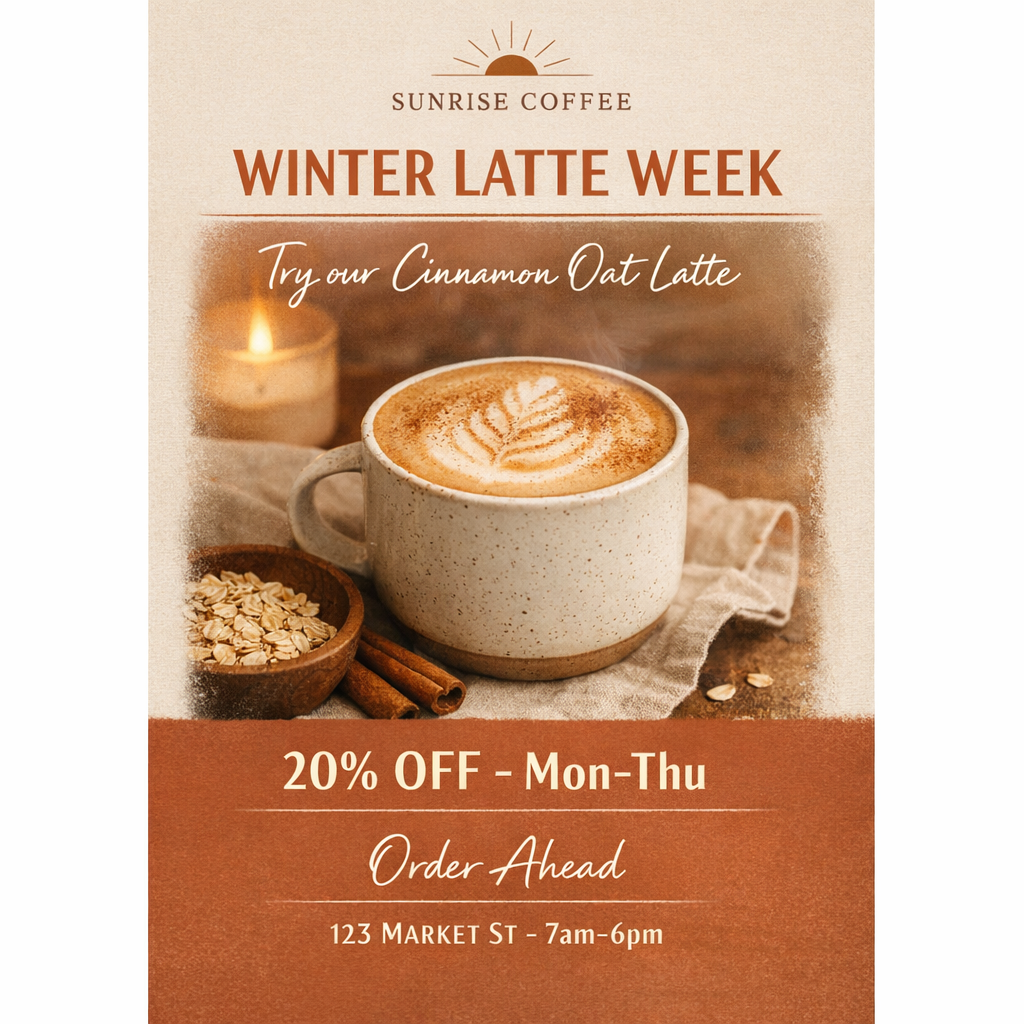

In [60]:
render_result_table(case=coffee_case, result=coffee_result, title="Coffee Flyer: Prompt vs. Scores")


### Method 2: Image-to-Text + Exact Copy Comparison

Another strict approach is to OCR the generated flyer with a vision model, then compare the extracted text lines against the required copy set.


In [61]:
coffee_image_path = Path(coffee_result["artifact_paths"][0])
extracted_lines = extract_text_from_flyer(coffee_image_path)

required_lines = sorted(REQUIRED_TEXT)
required_set = set(required_lines)
extracted_set = set(extracted_lines)

missing = sorted(required_set - extracted_set)
extra = sorted(extracted_set - required_set)

text_rendering_df = pd.DataFrame(
    {
        "text_rendering_score": [coffee_result["scores"].get("text_rendering")],
        "missing_text": ["\n".join(missing) or "(none)"],
        "extra_text": ["\n".join(extra) or "(none)"],
        "extracted_text": ["\n".join(extracted_lines) or "(no text extracted)"],
    }
)

text_rendering_df


,text_rendering_score,missing_text,extra_text,extracted_text
0,True,123 Market St • 7am–6pm\n20% OFF • Mon–Thu,123 Market St - 7am-6pm\n123 Market St - 7am-6...,SUNRISE COFFEE\nWINTER LATTE WEEK\nTry our Cin...


##### 6) Human feedback (quick and high leverage)

Marketing "vibe" is where humans add the most value. Keep it lightweight and consistent.

- Rubric labels (fast):
  - Would you ship this with minor edits? (Y/N)
  - If N, why? (text wrong / hierarchy unclear / off-brand / artifacts / other)
  - Overall quality: 1–5
- Pairwise preference (strong signal):
  - Which flyer better communicates the offer and feels more on-brand?
  - Use occasional anchor examples to recalibrate raters and prevent drift.
- Common failure tags (for debugging + iteration):
  - `text_hallucination_extra_copy`
  - `text_misspelling_or_symbol_error`
  - `cta_not_prominent`
  - `hierarchy_confusing`
  - `style_cartoonish_vs_photoreal`
  - `artifact_near_text`
  - `busy_background_competes_with_copy`


## Image Editing Evals

### Virtual Try-On

Virtual try-on (VTO) is an **image editing** workflow: given a **person
photo** (selfie or model) and a **garment reference** (product photo
and/or description), generate an output where the garment looks
**naturally worn**—while keeping the person’s identity, pose, and scene
intact.

**Why VTO evals are different**

Unlike “creative” edits, VTO is judged on **fidelity + preservation**:

- **Preserve the wearer** (face identity, body shape, pose)  
- **Preserve the product** (color, pattern, logos, material cues)  
- **Edit only what’s needed** (locality/preservation)  
- **Look physically plausible** (occlusions, lighting, drape, wrinkles)

#### What to evaluate (practical metrics):

##### 1) Treat VTO as a multi-reference editing task

For each test case, store:

- **Input person image** (selfie/model)  
- **Product reference** (catalog image(s), flat-lay, mannequin, or a
  “worn” reference when available)  
- Optional but high-leverage:
  - **Mask(s)**: editable region, clothing region, hair/hand occluders  
  - **Metadata**: category (top/bottom/outerwear), desired fit
    (oversized/slim), colorway, length  
  - **Edit instruction**: “Put on *this exact jacket* without changing
    background or face.”

This lets graders compare **output vs. both inputs** (person + product),
not just “does it look good?”

##### 2) Graded metrics (use only these three)

Use these as **0–5** scores to rank models and track improvement. Keep
them **separate** (don’t average them inside the grader); use verdict
rules outside if you want gates.

##### A) Facial similarity (output vs selfie) — 0–5

Measures whether the output preserves the *same person* (identity), not
just “a plausible face.”

- **5**: Clearly the same person; key facial features unchanged; no
  noticeable age/ethnicity/style drift; expression changes (if any) are
  minor and realistic.  
- **4**: Same person; tiny differences only noticeable on close
  inspection (minor shape/texture smoothing, slight eye/mouth drift).  
- **3**: Mostly the same person, but at least one noticeable identity
  drift (feature proportions, jawline, eyes, nose) that would reduce
  user trust.  
- **2**: Significant identity drift; looks like a different person or
  heavily altered face.  
- **1**: Major corruption (melted/blurry face) or clearly different
  identity.  
- **0**: Face missing, unreadable, or replaced.

What to look for:

- Facial geometry consistency (eyes/nose/mouth spacing, jawline,
  cheekbones)  
- Skin texture realism without “beauty filter” identity loss  
- No unintended makeup/age/style changes unless requested

##### B) Outfit fidelity (output vs provided items) — 0–5

Measures whether the output garment matches the *specific* product
reference(s) the user selected.

- **5**: Item matches reference closely: correct category, colorway,
  pattern/print, material cues, and key details (logos, seams, collar,
  pockets).  
- **4**: Clearly the same item; 1–2 minor deviations (small logo blur,
  slight hue shift, minor detail simplification).  
- **3**: Generally correct but with a notable mismatch (pattern scale
  wrong, material looks different, key design element missing/added).  
- **2**: Multiple mismatches; could be a different variant or different
  product.  
- **1**: Wrong item category or strongly incorrect visual identity.  
- **0**: Outfit not applied / missing / replaced with unrelated
  clothing.

What to look for:

- Color/pattern correctness (especially stripes, plaid, small repeats)  
- Logo/text integrity (no hallucinated letters)  
- Structural details (neckline, sleeves, hem, closures)

##### C) Body shape preservation (output vs selfie) — 0–5

Measures whether the model preserves the wearer’s body shape, pose, and
proportions **outside normal garment effects** (e.g., loose clothing can
change silhouette, but shouldn’t reshape anatomy).

- **5**: Body proportions and pose are preserved; garment conforms
  naturally without warping torso/limbs.  
- **4**: Minor, plausible silhouette changes consistent with clothing;
  no obvious anatomical distortion.  
- **3**: Noticeable reshaping (waist/hips/shoulders/limbs) that feels
  slightly “AI-stylized” or inconsistent with the input body.  
- **2**: Significant warping (elongated limbs, shifted joints,
  compressed torso) that would be unacceptable in product use.  
- **1**: Severe anatomical distortion (extra/missing limbs, melted body
  regions).  
- **0**: Body is not recognizable or is fundamentally corrupted.

What to look for:

- Shoulder/hip width consistency relative to input  
- Limb length/joint placement stability (elbows, knees, wrists)  
- No “body slimming” or “body inflation” artifacts

------------------------------------------------------------------------

If you want a single overall pass/fail, a common rule is:

- **Fail** if any metric ≤ 2  
- **Pass** if all metrics ≥ 3  
  (and optionally require outfit fidelity ≥ 4 for commerce-critical
  flows).

##### 3) Human feedback: keep it simple but consistent

Humans are best at “would I trust this in a shopping flow?”

Use two label types:

- **Rubric labels** (quick, structured):
  - Identity preserved? (Y/N)  
  - Garment matches reference? (Y/N + what’s wrong)  
  - Any bad artifacts? (none/minor/major)  
  - Overall usable for e-commerce? (Y/N)  
- **Pairwise preference** (A vs B):
  - Which output is more faithful to the product while keeping the person unchanged?

Add periodic **calibration**: keep a small set of “anchor” examples that
raters re-score to prevent drift.



### Virtual Try-On Example: Harness Setup

Use existing images from `images/` as the person and garment references.


In [62]:
vto_person_path = Path("../../images/base_woman.png")
vto_garment_path = Path("../../images/jacket.png")

vto_prompt = """Put the person in the first image into the jacket shown in the second image.
Keep the person's face, pose, body shape, and background unchanged.
Preserve the garment's color, pattern, and key details.
Do not add extra accessories, text, or new elements."""

vto_criteria = """The output preserves the same person and background.
The jacket matches the reference garment closely.
Body shape and pose remain consistent outside normal garment effects.
The result looks physically plausible."""

vto_case = TestCase(
    id="vto_jacket_tryon",
    task_type="image_editing",
    prompt=vto_prompt,
    criteria=vto_criteria,
    image_inputs=ImageInputs(image_paths=[vto_person_path, vto_garment_path]),
)

vto_run = ModelRun(
    label="gpt-image-1.5-vto",
    task_type="image_editing",
    params={
        "model": "gpt-image-1.5",
        "n": 1,
    },
)

vto_store = OutputStore(root=Path("../../images"))




### Virtual Try-On Example: Run And Grade

Define a VTO judge prompt aligned to the VTO metrics and run the harness.


In [63]:
vto_judge_prompt = """<core_mission>
Evaluate whether a virtual try-on edit preserves the person while accurately applying the reference garment.
</core_mission>

<role>
You are an expert evaluator of virtual try-on outputs.
You focus on identity preservation, garment fidelity, and body-shape preservation.
</role>

<metrics>
1) facial_similarity: 0-5
2) outfit_fidelity: 0-5
3) body_shape_preservation: 0-5
</metrics>

<verdict_rules>
FAIL if any metric <= 2.
PASS if all metrics >= 3.
</verdict_rules>

<output_constraints>
Return JSON only with the fields specified in the schema.
</output_constraints>
"""

vto_schema = {
    "type": "object",
    "properties": {
        "verdict": {"type": "string"},
        "facial_similarity": {"type": "number"},
        "outfit_fidelity": {"type": "number"},
        "body_shape_preservation": {"type": "number"},
        "reason": {"type": "string"},
    },
    "required": [
        "verdict",
        "facial_similarity",
        "outfit_fidelity",
        "body_shape_preservation",
        "reason",
    ],
    "additionalProperties": False,
}


def parse_vto_result(data: dict, base_key: str) -> list[Score]:
    return [
        Score(key="facial_similarity", value=float(data["facial_similarity"]), reason=""),
        Score(key="outfit_fidelity", value=float(data["outfit_fidelity"]), reason=""),
        Score(key="body_shape_preservation", value=float(data["body_shape_preservation"]), reason=""),
        Score(key="verdict", value=str(data["verdict"]), reason=(data.get("reason") or "").strip()),
    ]

vto_grader = LLMajRubricGrader(
    key="vto_eval",
    system_prompt=vto_judge_prompt,
    content_builder=build_editing_judge_content,
    judge_model="gpt-5.2",
    json_schema_name="vto_eval",
    json_schema=vto_schema,
    result_parser=parse_vto_result,
)

vto_results = evaluate(
    cases=[vto_case],
    model_runs=[vto_run],
    graders=[vto_grader],
    output_store=vto_store,
)

vto_result = vto_results[0]
vto_result


{'test_id': 'vto_jacket_tryon',
 'model_label': 'gpt-image-1.5-vto',
 'task_type': 'image_editing',
 'artifact_paths': ['../../images/edit_vto_jacket_tryon_gpt-image-1.5-vto_1769488885713_0.png'],
 'scores': {'facial_similarity': 5.0,
  'outfit_fidelity': 4.0,
  'body_shape_preservation': 4.0,
  'verdict': 'PASS'},
 'reasons': {'facial_similarity': '',
  'outfit_fidelity': '',
  'body_shape_preservation': '',
  'verdict': 'Face, hair, and expression match the original well, with the same pose and neutral studio background preserved. The applied jacket closely matches the reference: beige single-breasted blazer with notched lapels, two dark buttons, and flap pockets; overall color and structure are consistent, though minor differences in lapel/hem shaping and pocket proportions appear due to fit/rendering. Body shape and stance remain consistent, with plausible jacket drape and sleeve placement without noticeable distortions.'},
 'run_params': {'model': 'gpt-image-1.5', 'n': 1}}

### Virtual Try-On: Optional Code Interpreter Crop Tool

If you want finer-grained evidence (logos, seams, fit, face details), you can run a
secondary judge that uses the Code Interpreter `crop` tool to zoom into regions.
This is useful for close-up checks on garment fidelity and identity preservation.

In [64]:
vto_output_path = Path(vto_result["artifact_paths"][0])

instructions = """
Tools available:
- crop(image_id, x1, y1, x2, y2): Use to zoom into a specific image's region. Coordinates are integer pixels relative to the top-left of the CURRENT view of that image. Use as few precise crops as necessary to gather evidence.
    - When using crop(image_id, x1, y1, x2, y2), ensure that x2 > x1 and y2 > y1. The coordinates must define a valid rectangle: x1 (left, inclusive), y1 (top, inclusive), x2 (right, exclusive), y2 (bottom, exclusive), with x2 strictly greater than x1 and y2 strictly greater than y1. If you are unsure, double-check your coordinates before cropping to avoid errors.

Images provided:
- Up to 5 user reference photos (ref_1..ref_5) for identity/baseline body context
- 1 clothing-only image (clothing)
- 1 reconstruction image (recon)

Your goals:
1) Judge similarity between the clothing-only image and how it appears on the user in the reconstruction.
2) Judge identity realism (face/hair/skin) vs. user reference photos.
3) Judge overall realism (lighting, shadows, artifacts).

IMPORTANT:
- Use the crop tool when you need more detail. After crop, a new grid overlay is returned for that image.
- You may use the crop tool as many times as needed to gather evidence.
- When confident, produce the final STRICT JSON only. No extra text.
"""
judge_client = client if "client" in globals() else OpenAI()
response_crop = judge_client.responses.create(
    model="gpt-5.2",
    instructions=instructions,
    tools=[
        {
            "type": "code_interpreter",
            "container": {"type": "auto", "memory_limit": "4g"},
        }
    ],
    input=[
        {
            "role": "user",
            "content": [
                {
                    "type": "input_text",
                    "text": "Order: ref_1 (person), clothing (garment reference), recon (try-on output).",
                },
                {
                    "type": "input_image",
                    "image_url": image_to_data_url(vto_person_path),
                },
                {
                    "type": "input_image",
                    "image_url": image_to_data_url(vto_garment_path),
                },
                {
                    "type": "input_image",
                    "image_url": image_to_data_url(vto_output_path),
                },
            ],
        }
    ],
)

response_crop

Response(id='resp_0adacd169d70e53f006978422db60c819d8adc29370aeee0af', created_at=1769488941.0, error=None, incomplete_details=None, instructions="\nTools available:\n- crop(image_id, x1, y1, x2, y2): Use to zoom into a specific image's region. Coordinates are integer pixels relative to the top-left of the CURRENT view of that image. Use as few precise crops as necessary to gather evidence.\n    - When using crop(image_id, x1, y1, x2, y2), ensure that x2 > x1 and y2 > y1. The coordinates must define a valid rectangle: x1 (left, inclusive), y1 (top, inclusive), x2 (right, exclusive), y2 (bottom, exclusive), with x2 strictly greater than x1 and y2 strictly greater than y1. If you are unsure, double-check your coordinates before cropping to avoid errors.\n\nImages provided:\n- Up to 5 user reference photos (ref_1..ref_5) for identity/baseline body context\n- 1 clothing-only image (clothing)\n- 1 reconstruction image (recon)\n\nYour goals:\n1) Judge similarity between the clothing-only ima



### Virtual Try-On Example: Results Table

Show the edit result and VTO scores in a single pandas table.


Image,Input Prompt,Scores,Reasoning
,"Put the person in the first image into the jacket shown in the second image. Keep the person's face, pose, body shape, and background unchanged. Preserve the garment's color, pattern, and key details. Do not add extra accessories, text, or new elements. Criteria: The output preserves the same person and background. The jacket matches the reference garment closely. Body shape and pose remain consistent outside normal garment effects. The result looks physically plausible.",body_shape_preservation: 4.0 facial_similarity: 5.0 outfit_fidelity: 4.0 verdict: PASS,"Face, hair, and expression match the original well, with the same pose and neutral studio background preserved. The applied jacket closely matches the reference: beige single-breasted blazer with notched lapels, two dark buttons, and flap pockets; overall color and structure are consistent, though minor differences in lapel/hem shaping and pocket proportions appear due to fit/rendering. Body shape and stance remain consistent, with plausible jacket drape and sleeve placement without noticeable distortions."

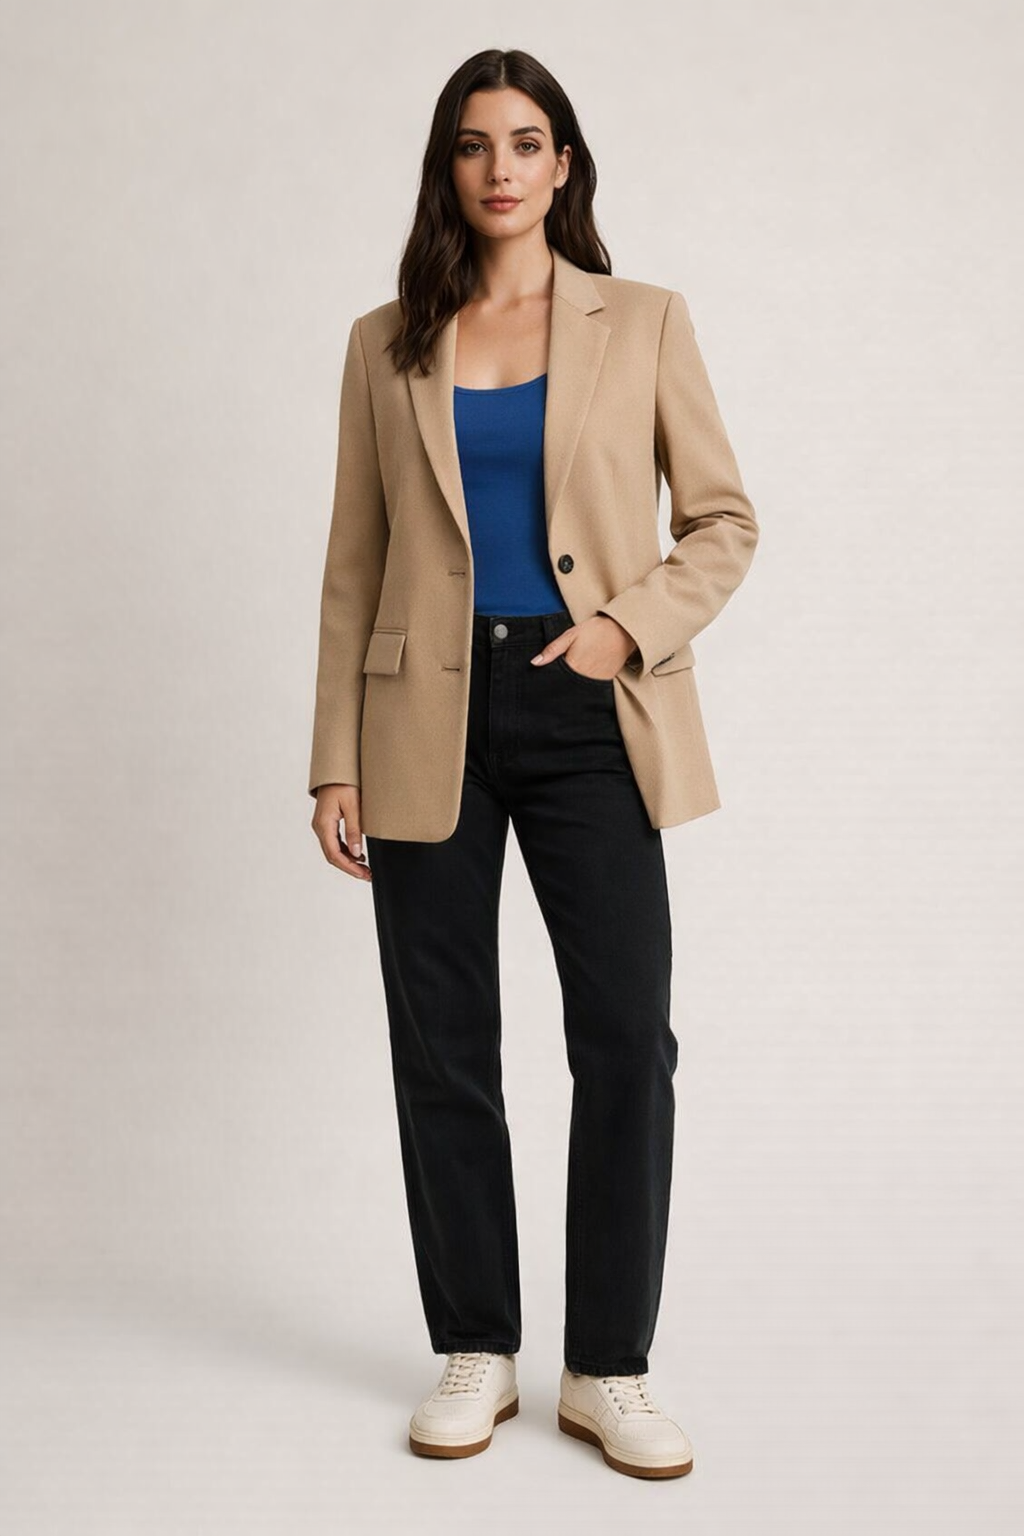

In [65]:
render_result_table(case=vto_case, result=vto_result, title="Virtual Try-On: Prompt vs. Scores")


### Logo editing (high precision editing)

Logo editing is a high-precision image editing task. Given an **existing
logo** and a **narrowly scoped instruction**, the model must apply the
exact requested change while preserving everything else perfectly.
Unlike creative design tasks, logo editing typically has a single
correct answer. Any deviation, even subtle, is a failure.

**Why Logo Editing evals are different**:

Logo editing is judged on exactness, locality, and preservation rather
than visual appeal:

- Preserve the original asset identity  
- Preserve all unedited text, geometry, spacing, and styling  
- Edit only the explicitly requested region  
- Produce character-level correctness with zero tolerance for drift

Small errors carry outsized risk. A single letter distortion, number
change, or spill outside the intended region can break brand integrity
and create downstream rework.

**Example Tasks:**

- Inputs: logo image + mask or region description  
- Tasks: “change the year from 2024 to 2026,” “replace C with S,” “add
  TM”

#### What to evaluate (practical metrics):

##### 1) Treat logo editing as a constrained, single-reference task

For each test case, store:

- **Input logo image**  
- **Edit instruction** with explicit scope  
- Optional but high-leverage:
  - Mask(s) or region description defining where edits are allowed  
  - Expected target text or symbol for exact comparison  
  - **Metadata**: font type, font size, or color

The grader should compare the output directly against the original logo.

##### 2) Graded metrics

Use these **0–5** scores to rank models and track improvement. Scores
are applied across all requested steps, not per step, so partial
completion is penalized in a controlled and explainable way.

##### A) Edit intent correctness — 0–5

Measures whether every requested edit step was applied correctly to the
correct target.

- **5**: All edit steps are applied exactly as specified.
  Character-level accuracy is perfect for every step.  
- **4**: All steps applied correctly; extremely minor visual
  imperfections only visible on close inspection.  
- **3**: All steps applied, but at least one step shows noticeable
  degradation in clarity or precision.  
- **2**: Most steps applied correctly, but one or more steps contain a
  meaningful error.  
- **1**: One or more steps are incorrect or applied to the wrong
  element.  
- **0**: Most steps missing, incorrect, or misapplied.

##### B) Non-target invariance — 0–5

Measures whether content outside the requested edits remains unchanged
across all steps.

- **5**: No detectable changes outside the requested edits.  
- **4**: Extremely minor drift visible only on close inspection.  
- **3**: Noticeable but limited drift in nearby elements.  
- **2**: Clear unrequested changes affecting adjacent text, symbols, or
  background.  
- **1**: Widespread unintended changes across the logo.  
- **0**: Logo identity compromised.

##### C) Character and style integrity — 0–5

Logo editing is not creative transformation. The output must preserve
the original asset’s identity including color, stroke, letterform, and
icon consistency.

- **5**: Edited characters and symbols perfectly match the original
  style. Colors, strokes, letterforms, and icons are indistinguishable
  from the original.  
- **4**: Extremely minor deviation visible only on close inspection,
  with no impact on brand perception.  
- **3**: Noticeable but limited deviation in one or more properties that
  does not break recognition.  
- **2**: Clear inconsistency in color, stroke, letterform, or icon
  geometry that affects visual cohesion.  
- **1**: Major inconsistency that materially alters the logo’s
  appearance.  
- **0**: Visual system is corrupted or no longer recognizable.

**LLM-as-judge rubric prompt**

Below is a judge prompt aligned to your existing `LLMajRubricGrader`. It
returns structured metric scores + an overall verdict.

You can use this with your existing grader by changing the JSON schema
to include the fields below (or create separate graders per metric if
you prefer).


In [66]:
PROMPT = """<core_mission>
Evaluate whether a logo edit was executed with exact correctness,
strict preservation, and high visual integrity.

Logo editing is a precision task.
Small errors matter.
Near-misses are failures.
</core_mission>

<role>
You are an expert evaluator of high-precision logo and brand asset editing.
You specialize in detecting subtle text errors, unintended changes,
and preservation drift across single-step and multi-step edits.
</role>

<scope_constraints>
- Judge only against the provided edit instruction and input logo.
- Do NOT judge aesthetics or visual appeal.
- Do NOT infer intent beyond what is explicitly stated.
- Be strict, conservative, and consistent across cases.
</scope_constraints>

<metrics_and_scoring>

Evaluate EACH metric independently using the definitions below.
All metrics are scored from 0 to 5.
Scores apply across ALL requested edit steps.

--------------------------------
1) Edit Intent Correctness (0–5)
--------------------------------
Measures whether every requested edit step was applied correctly
to the correct target.

5: All edit steps applied exactly as specified. Character-level
   accuracy is perfect for every step.
4: All steps applied correctly with extremely minor visual
   imperfections visible only on close inspection.
3: All steps applied, but one or more steps show noticeable
   degradation in clarity or precision.
2: Most steps applied correctly, but one or more steps contain
   a meaningful error.
1: One or more steps are incorrect or applied to the wrong element.
0: Most steps missing, incorrect, or misapplied.

What to consider:
- Exact character identity (letters, numbers, symbols)
- Correct sequencing and targeting of multi-step edits
- No ambiguous characters (Common confusions: 0 vs 6, O vs D, R vs B)

--------------------------------
2) Non-Target Invariance (0–5)
--------------------------------
Measures whether content outside the requested edits remains unchanged.

5: No detectable changes outside the requested edits.
4: Extremely minor drift visible only on close inspection.
3: Noticeable but limited drift in nearby elements.
2: Clear unrequested changes affecting adjacent text,
   symbols, or background.
1: Widespread unintended changes across the logo.
0: Logo identity compromised.

What to consider:
- Adjacent letter deformation or spacing shifts
- Background, texture, or color changes
- Cumulative drift from multi-step edits

--------------------------------
3) Character and Style Integrity (0–5)
--------------------------------
Measures whether the edited content preserves the original
logo’s visual system.

This includes color, stroke weight, letterform structure,
and icon geometry.

5: Edited characters and symbols perfectly match the original
   style. Colors, strokes, letterforms, and icons are
   indistinguishable from the original.
4: Extremely minor deviation visible only on close inspection,
   with no impact on brand perception.
3: Noticeable but limited deviation in one or more properties
   that does not break recognition.
2: Clear inconsistency in color, stroke, letterform, or icon
   geometry that affects visual cohesion.
1: Major inconsistency that materially alters the logo’s appearance.
0: Visual system is corrupted or no longer recognizable.

</metrics_and_scoring>

<verdict_rules>
- Edit Intent Correctness must be ≥ 4.
- Non-Target Invariance must be ≥ 4.
- Character and Style Integrity must be ≥ 4.

If ANY metric falls below threshold, the overall verdict is FAIL.
Do not average scores to determine the verdict.
</verdict_rules>

<consistency_rules>
- Score conservatively.
- If uncertain between two scores, choose the lower one.
- Base all scores on concrete visual observations.
- Penalize cumulative degradation across multi-step edits.
</consistency_rules>

<output_constraints>
Return JSON only.
No additional text.
</output_constraints>
"""


#### Recommended JSON Output


In [67]:
{
  "verdict": "PASS",
  "edit_intent_correctness": 5,
  "non_target_invariance": 5,
  "character_and_style_integrity": 5,
  "reason": "..."
}


{'verdict': 'PASS',
 'edit_intent_correctness': 5,
 'non_target_invariance': 5,
 'character_and_style_integrity': 5,
 'reason': '...'}



### Logo Editing Example: Harness Setup

Use an existing logo image and a narrowly scoped edit instruction.


In [68]:
# Capture the logo judge prompt.
logo_judge_prompt = PROMPT

logo_input_path = Path("../../images/logo_generation_1.png")

logo_prompt = """Edit the logo by changing the text from FIELD to BUTTER .
Do not change any other text, colors, shapes, or layout."""

logo_criteria = """The requested edit is applied exactly.
All non-target content remains unchanged.
Character style, color, and geometry remain consistent with the original."""

logo_case = TestCase(
    id="logo_year_edit",
    task_type="image_editing",
    prompt=logo_prompt,
    criteria=logo_criteria,
    image_inputs=ImageInputs(image_paths=[logo_input_path]),
)

logo_run = ModelRun(
    label="gpt-image-1.5-logo",
    task_type="image_editing",
    params={
        "model": "gpt-image-1.5",
        "n": 1,
    },
)

logo_store = OutputStore(root=Path("../../images"))




### Logo Editing Example: Run And Grade

Run the harness and score the logo edit using the logo judge rubric.


In [69]:
logo_schema = {
    "type": "object",
    "properties": {
        "verdict": {"type": "string"},
        "edit_intent_correctness": {"type": "number"},
        "non_target_invariance": {"type": "number"},
        "character_and_style_integrity": {"type": "number"},
        "reason": {"type": "string"},
    },
    "required": [
        "verdict",
        "edit_intent_correctness",
        "non_target_invariance",
        "character_and_style_integrity",
        "reason",
    ],
    "additionalProperties": False,
}


def parse_logo_result(data: dict, base_key: str) -> list[Score]:
    return [
        Score(key="edit_intent_correctness", value=float(data["edit_intent_correctness"]), reason=""),
        Score(key="non_target_invariance", value=float(data["non_target_invariance"]), reason=""),
        Score(key="character_and_style_integrity", value=float(data["character_and_style_integrity"]), reason=""),
        Score(key="verdict", value=str(data["verdict"]), reason=(data.get("reason") or "").strip()),
    ]

logo_grader = LLMajRubricGrader(
    key="logo_eval",
    system_prompt=logo_judge_prompt,
    content_builder=build_editing_judge_content,
    judge_model="gpt-5.2",
    json_schema_name="logo_eval",
    json_schema=logo_schema,
    result_parser=parse_logo_result,
)

logo_results = evaluate(
    cases=[logo_case],
    model_runs=[logo_run],
    graders=[logo_grader],
    output_store=logo_store,
)

logo_result = logo_results[0]
logo_result


{'test_id': 'logo_year_edit',
 'model_label': 'gpt-image-1.5-logo',
 'task_type': 'image_editing',
 'artifact_paths': ['../../images/edit_logo_year_edit_gpt-image-1.5-logo_1769488975889_0.png'],
 'scores': {'edit_intent_correctness': 4.0,
  'non_target_invariance': 1.0,
  'character_and_style_integrity': 2.0,
  'verdict': 'FAIL'},
 'reasons': {'edit_intent_correctness': '',
  'non_target_invariance': '',
  'character_and_style_integrity': '',
  'verdict': "Target text edit appears applied: 'FIELD' was changed to 'BUTTER' (now reads 'BUTTER & FLOUR'). However, major non-target changes occurred: the background shifted from a gray vignette/glow to a solid black field, and overall rendering/contrast of the mark differs. Style integrity also drifts: the edited output shows different tonal balance/shading and edge quality compared to the original, not a strict preservation of colors and geometry across the full logo."},
 'run_params': {'model': 'gpt-image-1.5', 'n': 1}}



### Logo Editing Example: Results Table

Show the edited logo and logo edit scores in a single pandas table.


Image,Input Prompt,Scores,Reasoning
,"Edit the logo by changing the text from FIELD to BUTTER . Do not change any other text, colors, shapes, or layout. Criteria: The requested edit is applied exactly. All non-target content remains unchanged. Character style, color, and geometry remain consistent with the original.",character_and_style_integrity: 2.0 edit_intent_correctness: 4.0 non_target_invariance: 1.0 verdict: FAIL,"Target text edit appears applied: 'FIELD' was changed to 'BUTTER' (now reads 'BUTTER & FLOUR'). However, major non-target changes occurred: the background shifted from a gray vignette/glow to a solid black field, and overall rendering/contrast of the mark differs. Style integrity also drifts: the edited output shows different tonal balance/shading and edge quality compared to the original, not a strict preservation of colors and geometry across the full logo."

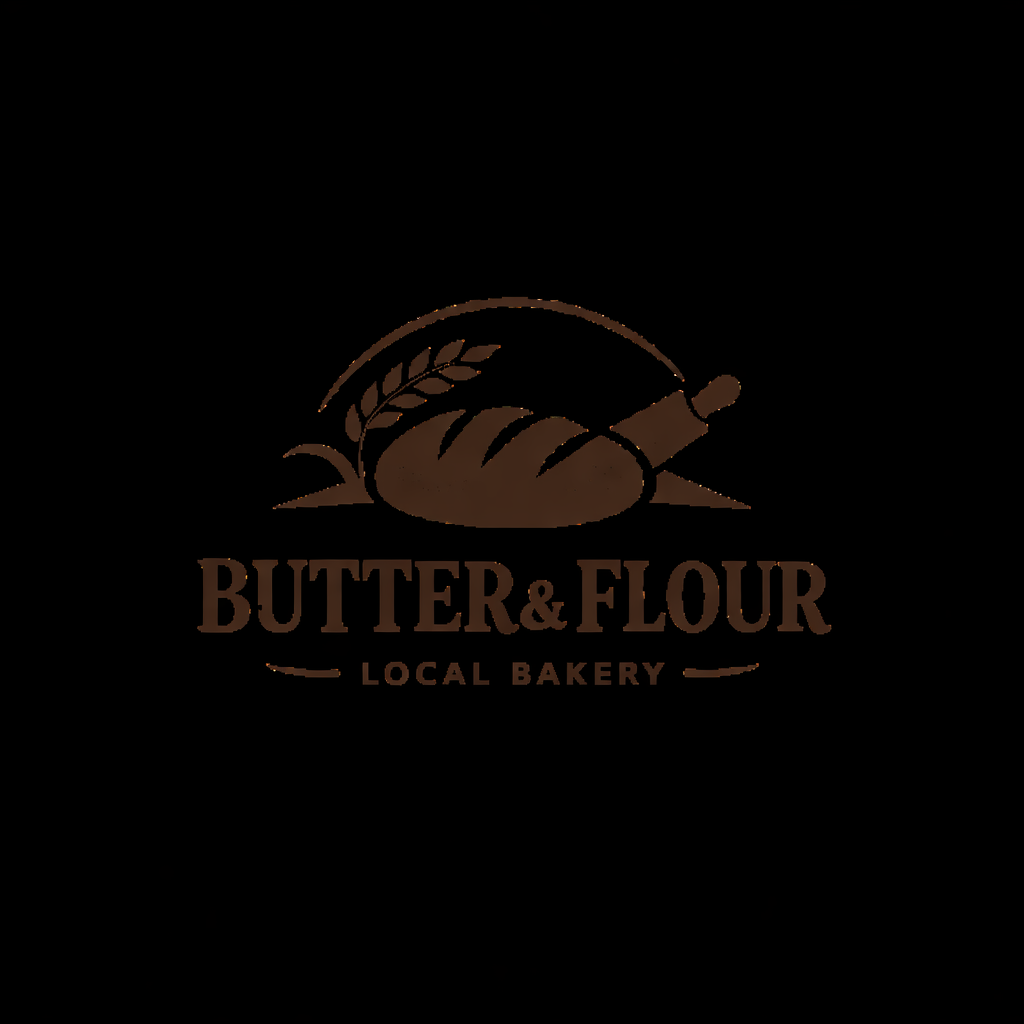

In [70]:
render_result_table(case=logo_case, result=logo_result, title="Logo Editing: Prompt vs. Scores")


##### 3) Alternative When You Have Ground Truth Images

If you already have canonical references, you can compare directly to a
**design source-of-truth** rather than model outputs.

Ground truth should come from the design system, not generated images:

- Brand library assets (vector or high-res canonical raster)
- Figma frames or components representing the correct asset state

This maps cleanly to logo editing requirements like “still the same asset”
and “unintended drift is a failure.”

**Example: OpenAI Logo – Lunar New Year**

- Reference image: canonical OpenAI logo (from Figma or brand assets)
- Generated image: model output with the requested transformation



## Conclusion

Image models are shifting from “cool demos” to production tools that
generate real artifacts—screens, flyers, product visuals, and brand
edits that influence decisions and ship to customers. The core lesson of
this cookbook is simple: you can’t evaluate these systems with generic
“looks good” scores. You need **workflow-specific evals** that are
**repeatable** across model versions, prompts, and settings. Multimodal
LLMs make this practical by acting as scalable judges—when paired with
tight rubrics, structured outputs, and human calibration.

A practical vision-eval program starts small and gets sharper over time:

- **Start with gates.** Add strict pass/fail graders for the failure
  modes that break real work: missing required components, incorrect
  copy, edits spilling outside the intended region, or unintended
  changes to preserved areas. This prevents “pretty but wrong” outputs
  from masking regressions.  
- **Layer in graded metrics.** Once hard failures are controlled, use
  0–5 rubrics to capture what matters for usability and quality in each
  workflow (e.g., hierarchy in UI mockups, brand fit in marketing, or
  fidelity/preservation in editing).  
- **Tag failures to iterate faster.** Consistent failure tags turn a
  pile of outputs into actionable engineering work: you can quantify
  what’s breaking, find clustered root causes, and track progress as you
  tune prompts, model settings, masks, or post-processing.  
- **Use humans strategically.** Humans add the most value on subjective
  or ambiguous dimensions (“vibe,” usability clarity, trustworthiness),
  but only if you keep rubrics tight and use calibration anchors to
  prevent drift.  
- **Treat the harness as a product.** The reusable harness you
  built—test cases, runners, graders, and stored artifacts—creates the
  foundation for regression testing, parameter sweeps, and side-by-side
  comparisons. Over time, your eval suite becomes your safety net: it
  catches subtle failures early and makes improvements measurable.

Build evals that reflect how images are actually used, enforce
correctness before aesthetics, and make iteration data-driven. When your
evals are aligned with real workflow requirements, image generation and
editing stop being unpredictable art projects and become tools teams can
trust.
